In [4]:
!pip install -q kokoro>=0.9.2 soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1

In [20]:
import os
import time
import numpy as np
import pandas as pd
import torch
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from IPython.display import Audio
from kokoro import KPipeline

In [21]:
def initialize_pipeline(lang_code='a'):
    print("Initializing Kokoro Pipeline...")

    try:
        pipeline = KPipeline(lang_code=lang_code)
        print(f"Pipeline initialized successfully with language code: {lang_code}")
        return pipeline
    except Exception as e:
        print(f"Error initializing pipeline: {e}")
        return None


In [22]:
def prepare_test_data():

    # GPT generated test sentences
    test_sentences = [
        "The quick brown fox jumps over the lazy dog.",
        "How much wood would a woodchuck chuck if a woodchuck could chuck wood?",
        "Artificial intelligence is transforming the way we interact with technology.",
        "The rain in Spain stays mainly in the plain.",
        "To be, or not to be, that is the question.",
        "Please call Stella. Ask her to bring these things with her from the store.",
        "The surface of Mars has features reminiscent of both the impact craters of the Moon and the valleys, deserts and polar ice caps of Earth.",
        "1984 was published on June 8, 1949.",
        "E = mc².",
        "😊 🎵 ⚽ emojis and symbols test.",
    ]


    os.makedirs("kokoro_test_outputs", exist_ok=True)

    return test_sentences

In [23]:
def test_generation_time(pipeline, test_sentences, voice="af_heart", speed=1.0, lang_code='a'): #testing generation and speed

    print(f"\nTesting speech generation time with voice: {voice}, speed: {speed}...")


    output_dir = f"kokoro_test_outputs/{lang_code}_voice_{voice}_speed_{speed}".replace(".", "_")
    os.makedirs(output_dir, exist_ok=True)

    timing_results = []

    for i, sentence in enumerate(tqdm(test_sentences)):
        output_path = f"{output_dir}/test_{i}.wav"


        start_time = time.time()

        try:

            generator = pipeline(sentence, voice=voice, speed=speed)


            for j, (gs, ps, audio) in enumerate(generator):
                if j == 0:
                    sf.write(output_path, audio, 24000)

            end_time = time.time()
            duration = end_time - start_time


            timing_results.append({
                "text": sentence,
                "duration": duration,
                "text_length": len(sentence),
                "chars_per_second": len(sentence) / duration,
                "output_path": output_path,
                "voice": voice,
                "speed": speed,
                "language": lang_code
            })

        except Exception as e:
            print(f"Error generating audio for: '{sentence}'")
            print(f"Error message: {e}")
            timing_results.append({
                "text": sentence,
                "duration": None,
                "text_length": len(sentence),
                "chars_per_second": None,
                "output_path": None,
                "voice": voice,
                "speed": speed,
                "language": lang_code
            })


    timing_df = pd.DataFrame(timing_results)


    timing_df.to_csv(f"{output_dir}/timing_results.csv", index=False)

    return timing_df, output_dir


In [24]:
def analyze_timing_results(timing_df, output_dir):

    print("\nAnalyzing generation time results...")

    if timing_df['duration'].isna().all():
        print("No valid timing data available for analysis.")
        return


    valid_df = timing_df.dropna(subset=['duration'])

    if len(valid_df) == 0:
        print("No valid timing data available for analysis.")
        return

    print(f"Average generation time: {valid_df['duration'].mean():.4f} seconds")
    print(f"Average characters per second: {valid_df['chars_per_second'].mean():.2f}")
    print(f"Min generation time: {valid_df['duration'].min():.4f} seconds")
    print(f"Max generation time: {valid_df['duration'].max():.4f} seconds")

    plt.figure(figsize=(12, 6))
    plt.scatter(valid_df['text_length'], valid_df['duration'])
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Generation Time (seconds)')
    plt.title(f'Kokoro TTS Generation Time vs Text Length (Voice: {valid_df["voice"].iloc[0]}, Speed: {valid_df["speed"].iloc[0]})')


    if len(valid_df) > 1:
        z = np.polyfit(valid_df['text_length'], valid_df['duration'], 1)
        p = np.poly1d(z)
        plt.plot(valid_df['text_length'], p(valid_df['text_length']), "r--")
        plt.text(max(valid_df['text_length'])*0.7, max(valid_df['duration'])*0.8,
                f"y = {z[0]:.4f}x + {z[1]:.4f}", fontsize=12)

    plt.grid(True)
    plt.savefig(f"{output_dir}/generation_time_plot.png")
    print(f"Generation time plot saved to '{output_dir}/generation_time_plot.png'")

In [25]:
def analyze_audio_quality(audio_path): #audio quality metrics

    try:

        y, sr = librosa.load(audio_path, sr=None)


        duration = librosa.get_duration(y=y, sr=sr)
        rms_energy = librosa.feature.rms(y=y).mean()
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y).mean()


        pitches, magnitudes = librosa.piptrack(y=y, sr=sr) #pitch
        pitch = 0
        if np.any(magnitudes):
            indices = magnitudes > np.max(magnitudes, axis=0) * 0.8
            valid_pitches = pitches[indices]
            if len(valid_pitches) > 0:
                pitch = np.mean(valid_pitches)


        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr) #mel spectrogram
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return {
            "duration": duration,
            "rms_energy": float(rms_energy),
            "spectral_centroid": float(spectral_centroid),
            "spectral_bandwidth": float(spectral_bandwidth),
            "zero_crossing_rate": float(zero_crossing_rate),
            "estimated_pitch": float(pitch),
            "mel_spectrogram": mel_spec_db
        }
    except Exception as e:
        print(f"Error analyzing audio file {audio_path}: {e}")
        return None

In [26]:
def test_audio_quality(output_dir, test_sentences):

    print(f"\nAnalyzing audio quality for samples in {output_dir}...")

    audio_quality_results = []

    for i, sentence in enumerate(test_sentences):
        audio_path = f"{output_dir}/test_{i}.wav"

        if os.path.exists(audio_path):
            result = analyze_audio_quality(audio_path)
            if result:
                result["text"] = sentence
                result["file"] = audio_path
                audio_quality_results.append(result)
        else:
            print(f"Audio file {audio_path} does not exist. Skipping analysis.")


    quality_df = pd.DataFrame([{k: v for k, v in result.items() if k != 'mel_spectrogram'}
                              for result in audio_quality_results])


    quality_df.to_csv(f"{output_dir}/audio_quality_results.csv", index=False)


    if audio_quality_results:
        n_samples = min(4, len(audio_quality_results))
        plt.figure(figsize=(15, 10))

        for i in range(n_samples):
            plt.subplot(n_samples, 1, i+1)
            librosa.display.specshow(audio_quality_results[i]['mel_spectrogram'],
                                   sr=24000,  # Kokoro's sample rate is 24000
                                   x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel Spectrogram - Sample {i}: {audio_quality_results[i]['text'][:40]}...")
            plt.tight_layout()

        plt.savefig(f"{output_dir}/mel_spectrograms.png")
        print(f"Mel spectrograms saved to '{output_dir}/mel_spectrograms.png'")

    return quality_df


In [27]:
def stress_test_long_text(pipeline, voice="af_heart", speed=1.0, lang_code='a'):

    print(f"\nStress testing with longer text (voice: {voice}, speed: {speed})...")


    output_dir = f"kokoro_test_outputs/stress_test_{lang_code}_voice_{voice}_speed_{speed}".replace(".", "_")
    os.makedirs(output_dir, exist_ok=True)

    long_text = """
    The sky above the port was the color of television, tuned to a dead channel.
    "It's not like I'm using," Case heard someone say, as he shouldered his way through the crowd around the door of the Chat. "It's like my body's developed this massive drug deficiency."
    It was a Sprawl voice and a Sprawl joke. The Chatsubo was a bar for professional expatriates; you could drink there for a week and never hear two words in Japanese.

    These were to have an enormous impact, not only because they were associated with Constantine, but also because, as in so many other areas, the decisions taken by Constantine (or in his name) were to have great significance for centuries to come. One of the main issues was the shape that Christian churches were to take, since there was not, apparently, a tradition of monumental church buildings when Constantine decided to help the Christian church build a series of truly spectacular structures. The main form that these churches took was that of the basilica, a multipurpose rectangular structure, based ultimately on the earlier Greek stoa, which could be found in most of the great cities of the empire. Christianity, unlike classical polytheism, needed a large interior space for the celebration of its religious services, and the basilica aptly filled that need.
    """


    output_path = f"{output_dir}/long_text.wav"

    start_time = time.time()

    try:

        generator = pipeline(long_text, voice=voice, speed=speed, split_pattern=r'\n+')


        all_audio = []
        for i, (gs, ps, audio) in enumerate(generator):
            all_audio.append(audio)


            sf.write(f"{output_dir}/segment_{i}.wav", audio, 24000)


        if all_audio:
            full_audio = np.concatenate(all_audio)
            sf.write(output_path, full_audio, 24000)

        end_time = time.time()
        duration = end_time - start_time

        result = {
            "duration": duration,
            "text_length": len(long_text),
            "chars_per_second": len(long_text) / duration,
            "segments": len(all_audio),
            "output_path": output_path,
            "voice": voice,
            "speed": speed,
            "language": lang_code
        }


        pd.DataFrame([result]).to_csv(f"{output_dir}/stress_test_results.csv", index=False)

        print(f"Long text generation time: {duration:.2f} seconds")
        print(f"Characters per second: {len(long_text) / duration:.2f}")
        print(f"Number of segments: {len(all_audio)}")

        return result

    except Exception as e:
        print(f"Error in stress test: {e}")
        return None

In [28]:
def test_pronunciation(pipeline, voice="af_heart", speed=1.0, lang_code='a'):

    print(f"\nTesting pronunciation accuracy (voice: {voice}, speed: {speed})...")


    output_dir = f"kokoro_test_outputs/pronunciation_{lang_code}_voice_{voice}_speed_{speed}".replace(".", "_")
    os.makedirs(output_dir, exist_ok=True)

    #GPT generated test sentences for pronunciation
    pronunciation_test_sentences = [
        "The physician prescribed an antibiotic for the patient's pneumonia.",
        "Worcester, Leicester, and Gloucestershire are difficult to pronounce.",
        "The entrepreneurial phenomenon prioritized the acquisition of cryptocurrency.",
        "She sells seashells by the seashore.",
        "The sixth sick sheikh's sixth sheep's sick.",
        "PyTorch, TensorFlow, and scikit-learn are popular machine learning libraries.",
        "Los Ángeles está en California, y Madrid está en España.",
        "The pH of the solution is 7.4, while the temperature is 22°C.",
        "Chat GPT-4 was released in 2023 as an advanced AI model.",
        "Colonel Nguyen analyzed the debris from the fuselage of the Boeing 787.",
    ]


    pronunciation_results = []
    phoneme_results = []

    for i, sentence in enumerate(tqdm(pronunciation_test_sentences)):
        output_path = f"{output_dir}/test_{i}.wav"

        try:

            start_time = time.time()
            generator = pipeline(sentence, voice=voice, speed=speed)


            for j, (gs, ps, audio) in enumerate(generator):
                if j == 0:
                    sf.write(output_path, audio, 24000)

                    phoneme_results.append({
                        "text": sentence,
                        "phonemes": ps
                    })

            end_time = time.time()
            duration = end_time - start_time


            pronunciation_results.append({
                "text": sentence,
                "duration": duration,
                "text_length": len(sentence),
                "chars_per_second": len(sentence) / duration,
                "output_path": output_path
            })

        except Exception as e:
            print(f"Error generating pronunciation test for: '{sentence}'")
            print(f"Error message: {e}")
            pronunciation_results.append({
                "text": sentence,
                "duration": None,
                "text_length": len(sentence),
                "chars_per_second": None,
                "output_path": None
            })


    pron_df = pd.DataFrame(pronunciation_results)
    phoneme_df = pd.DataFrame(phoneme_results)


    pron_df.to_csv(f"{output_dir}/pronunciation_results.csv", index=False)
    phoneme_df.to_csv(f"{output_dir}/phoneme_results.csv", index=False)

    return pron_df, phoneme_df, pronunciation_test_sentences, output_dir

In [29]:
def test_speed_parameters(pipeline, voice="af_heart", lang_code='a'):

    print("\nTesting different speed parameters...")

    test_sentence = "This is a test of different speech parameters."
    speeds = [0.8, 1.0, 1.2, 1.5]
    speed_results = []


    output_dir = f"kokoro_test_outputs/speed_test_{lang_code}_voice_{voice}"
    os.makedirs(output_dir, exist_ok=True)

    for speed in speeds:

        output_path = f"{output_dir}/speed_{str(speed).replace('.', '_')}.wav"

        try:

            start_time = time.time()
            generator = pipeline(test_sentence, voice=voice, speed=speed)


            for i, (gs, ps, audio) in enumerate(generator):
                if i == 0:
                    sf.write(output_path, audio, 24000)

            end_time = time.time()
            duration = end_time - start_time


            speed_results.append({
                "speed": speed,
                "duration": duration,
                "output_path": output_path
            })

            print(f"Speed {speed}: Generated in {duration:.2f} seconds")

        except Exception as e:
            print(f"Error testing speed {speed}: {e}")
            speed_results.append({
                "speed": speed,
                "duration": None,
                "output_path": None
            })


    speed_df = pd.DataFrame(speed_results)
    speed_df.to_csv(f"{output_dir}/speed_results.csv", index=False)

    return speed_df, output_dir

In [30]:
def test_voices(pipeline, lang_code='a'):

    print("\nTesting different voice options...")

    test_sentence = "This is a test of different voice options."


    voices = ["af_heart", "af_jessica", "af_bella"]

    voice_results = []


    output_dir = f"kokoro_test_outputs/voice_test_{lang_code}".replace(".", "_")
    os.makedirs(output_dir, exist_ok=True)

    for voice in voices:
        output_path = f"{output_dir}/voice_{voice}.wav"

        try:

            start_time = time.time()
            generator = pipeline(test_sentence, voice=voice, speed=1.0)


            for i, (gs, ps, audio) in enumerate(generator):
                if i == 0:
                    sf.write(output_path, audio, 24000)

            end_time = time.time()
            duration = end_time - start_time


            voice_results.append({
                "voice": voice,
                "duration": duration,
                "output_path": output_path
            })

            print(f"Voice {voice}: Generated in {duration:.2f} seconds")

        except Exception as e:
            print(f"Error testing voice {voice}: {e}")
            voice_results.append({
                "voice": voice,
                "duration": None,
                "output_path": None
            })


    voice_df = pd.DataFrame(voice_results)
    voice_df.to_csv(f"{output_dir}/voice_results.csv", index=False)

    return voice_df, output_dir

In [31]:
def test_multilingual(english_pipeline, test_english=True, test_french=True, test_hindi=True):

    print("\nTesting multilingual capabilities...")

    results = {}


    if test_english:
        print("\nTesting English (lang_code='a', American English)...")
        english_sentences = [
            "The quick brown fox jumps over the lazy dog.",
            "Hello, how are you doing today?",
            "Artificial intelligence is transforming many industries."
        ]

        english_df, english_dir = test_generation_time(english_pipeline, english_sentences, voice="af_heart", lang_code='a')
        english_quality = test_audio_quality(english_dir, english_sentences)

        results["english"] = {
            "df": english_df,
            "quality": english_quality,
            "dir": english_dir
        }


    if test_french:
        try:
            print("\nInitializing French pipeline (lang_code='f')...")
            french_pipeline = KPipeline(lang_code='f')  # 'f' for French (fr-fr)

            french_sentences = [
                "Le renard brun rapide saute par-dessus le chien paresseux.",
                "Bonjour, comment allez-vous aujourd'hui?",
                "L'intelligence artificielle transforme de nombreuses industries."
            ]

            french_df, french_dir = test_generation_time(french_pipeline, french_sentences, voice="af_heart", lang_code='f')
            french_quality = test_audio_quality(french_dir, french_sentences)

            results["french"] = {
                "df": french_df,
                "quality": french_quality,
                "dir": french_dir
            }

        except Exception as e:
            print(f"Error testing French: {e}")


    if test_hindi:
        try:
            print("\nInitializing Hindi pipeline (lang_code='h')...")
            hindi_pipeline = KPipeline(lang_code='h')  # 'h' for Hindi

            hindi_sentences = [
                "तेज़ भूरा लोमड़ी आलसी कुत्ते पर कूदता है।",
                "नमस्ते, आप कैसे हैं?",
                "कृत्रिम बुद्धिमत्ता कई उद्योगों को बदल रही है।"
            ]

            hindi_df, hindi_dir = test_generation_time(hindi_pipeline, hindi_sentences, voice="af_heart", lang_code='h')
            hindi_quality = test_audio_quality(hindi_dir, hindi_sentences)

            results["hindi"] = {
                "df": hindi_df,
                "quality": hindi_quality,
                "dir": hindi_dir
            }

        except Exception as e:
            print(f"Error testing Hindi: {e}")

    return results

In [32]:
def summarize_results(results_dict):

    print("\n" + "="*50)
    print("KOKORO TTS MODEL TEST RESULTS SUMMARY")
    print("="*50)


    summary_rows = []


    for test_name, test_data in results_dict.items():
        if "timing_df" in test_data and test_data["timing_df"] is not None:
            df = test_data["timing_df"]
            valid_df = df.dropna(subset=['duration'])

            if not valid_df.empty:
                avg_time = valid_df['duration'].mean()
                avg_cps = valid_df['chars_per_second'].mean()

                summary_rows.append({
                    "Test": test_name,
                    "Avg. Time (s)": f"{avg_time:.4f}",
                    "Chars/Second": f"{avg_cps:.2f}",
                    "Voice": valid_df['voice'].iloc[0] if 'voice' in valid_df else "N/A",
                    "Speed": valid_df['speed'].iloc[0] if 'speed' in valid_df else "N/A",
                    "Language": valid_df['language'].iloc[0] if 'language' in valid_df else "N/A"
                })


    if "multilingual" in results_dict:
        multi_results = results_dict["multilingual"]
        multi_rows = []

        for lang, lang_data in multi_results.items():
            df = lang_data["df"]
            valid_df = df.dropna(subset=['duration'])

            if not valid_df.empty:
                avg_time = valid_df['duration'].mean()
                avg_cps = valid_df['chars_per_second'].mean()

                multi_rows.append({
                    "Language": lang,
                    "Avg. Time (s)": f"{avg_time:.4f}",
                    "Chars/Second": f"{avg_cps:.2f}"
                })

        print("\n=== MULTILINGUAL COMPARISON ===")
        if multi_rows:
            print(pd.DataFrame(multi_rows).to_string(index=False))
        else:
            print("No valid multilingual data available.")


    if "speed_df" in results_dict and results_dict["speed_df"] is not None:
        speed_df = results_dict["speed_df"]
        valid_speed_df = speed_df.dropna(subset=['duration'])

        if not valid_speed_df.empty:
            print("\n=== SPEED PARAMETER RESULTS ===")
            print(valid_speed_df[['speed', 'duration']].to_string(index=False))


    print("\n=== OVERALL SUMMARY ===")
    if summary_rows:
        print(pd.DataFrame(summary_rows).to_string(index=False))
    else:
        print("No valid summary data available.")

    print("\nAll test outputs are saved in the 'kokoro_test_outputs' directory.")


KOKORO TTS MODEL TESTING SCRIPT
Initializing Kokoro Pipeline...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Pipeline initialized successfully with language code: a

Testing speech generation time with voice: af_heart, speed: 1.0...


100%|██████████| 10/10 [01:08<00:00,  6.89s/it]



Analyzing generation time results...
Average generation time: 6.8850 seconds
Average characters per second: 7.90
Min generation time: 4.2670 seconds
Max generation time: 13.8049 seconds
Generation time plot saved to 'kokoro_test_outputs/a_voice_af_heart_speed_1_0/generation_time_plot.png'

Analyzing audio quality for samples in kokoro_test_outputs/a_voice_af_heart_speed_1_0...
Mel spectrograms saved to 'kokoro_test_outputs/a_voice_af_heart_speed_1_0/mel_spectrograms.png'

Stress testing with longer text (voice: af_heart, speed: 1.0)...
Long text generation time: 149.35 seconds
Characters per second: 8.87
Number of segments: 5

Testing pronunciation accuracy (voice: af_heart, speed: 1.0)...


100%|██████████| 10/10 [01:13<00:00,  7.33s/it]



Testing different speed parameters...
Speed 0.8: Generated in 5.64 seconds
Speed 1.0: Generated in 4.44 seconds
Speed 1.2: Generated in 5.04 seconds
Speed 1.5: Generated in 3.02 seconds

Testing different voice options...
Voice af_heart: Generated in 4.26 seconds
Voice af_jessica: Generated in 5.73 seconds
Voice af_bella: Generated in 4.67 seconds

Testing multilingual capabilities...

Testing English (lang_code='a', American English)...

Testing speech generation time with voice: af_heart, speed: 1.0...


100%|██████████| 3/3 [00:14<00:00,  4.79s/it]



Analyzing audio quality for samples in kokoro_test_outputs/a_voice_af_heart_speed_1_0...
Mel spectrograms saved to 'kokoro_test_outputs/a_voice_af_heart_speed_1_0/mel_spectrograms.png'

Initializing French pipeline (lang_code='f')...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)



Testing speech generation time with voice: af_heart, speed: 1.0...


100%|██████████| 3/3 [00:19<00:00,  6.49s/it]



Analyzing audio quality for samples in kokoro_test_outputs/f_voice_af_heart_speed_1_0...
Mel spectrograms saved to 'kokoro_test_outputs/f_voice_af_heart_speed_1_0/mel_spectrograms.png'

Initializing Hindi pipeline (lang_code='h')...

Testing speech generation time with voice: af_heart, speed: 1.0...


100%|██████████| 3/3 [00:14<00:00,  4.93s/it]



Analyzing audio quality for samples in kokoro_test_outputs/h_voice_af_heart_speed_1_0...


<ipython-input-26-de387f96a7d5>:38: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-de387f96a7d5>:38: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
<ipython-input-26-de387f96a7d5>:38: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-de387f96a7d5>:38: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-de387f96a7d5>:38: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-de387f96a7d5>:38: UserWarning: Glyph 2349 (\N{DEVANAGARI LETTER BHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-de387f96a7d5>:38: UserWarning: Glyph 2370 (\N{DEVANAGARI VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-i

Mel spectrograms saved to 'kokoro_test_outputs/h_voice_af_heart_speed_1_0/mel_spectrograms.png'

KOKORO TTS MODEL TEST RESULTS SUMMARY

=== MULTILINGUAL COMPARISON ===
Language Avg. Time (s) Chars/Second
 english        4.7893         9.02
  french        6.4863         8.40
   hindi        4.9263         7.04

=== OVERALL SUMMARY ===
         Test Avg. Time (s) Chars/Second    Voice Speed Language
        basic        6.8850         7.90 af_heart   1.0        a
pronunciation        7.3257         8.74      N/A   N/A      N/A

All test outputs are saved in the 'kokoro_test_outputs' directory.

Test completed successfully!


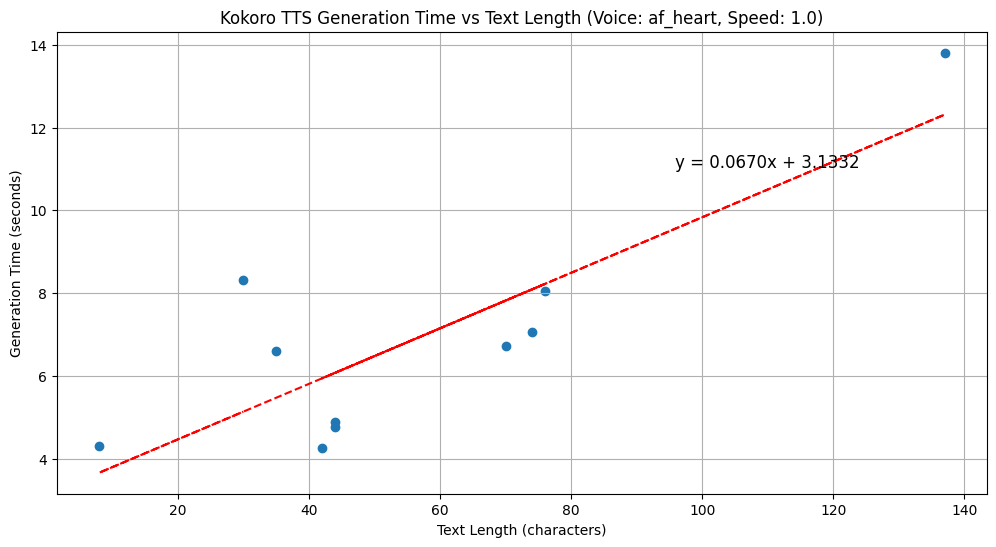

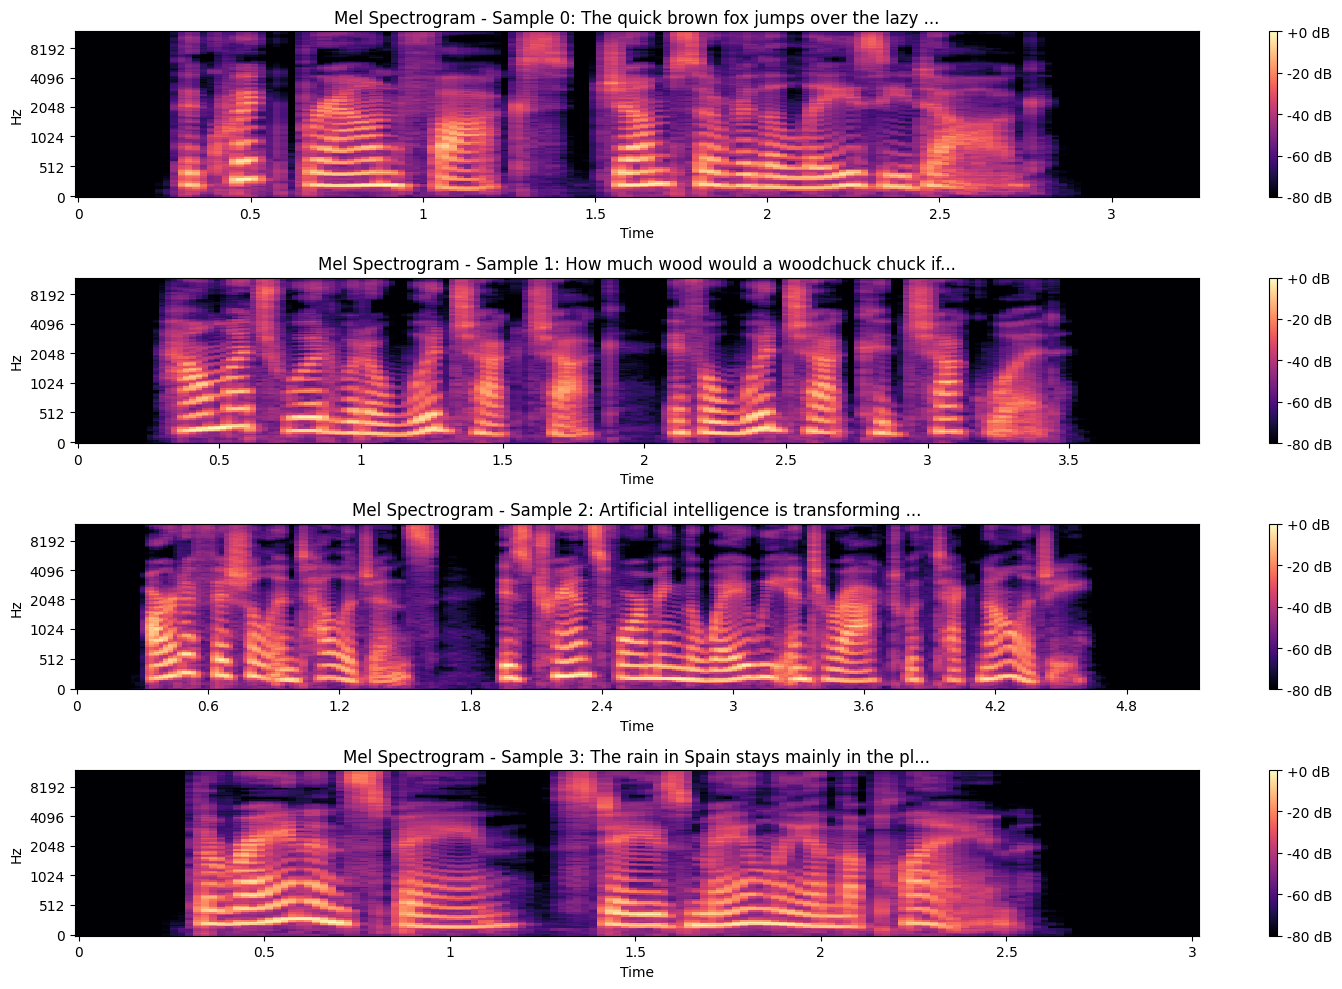

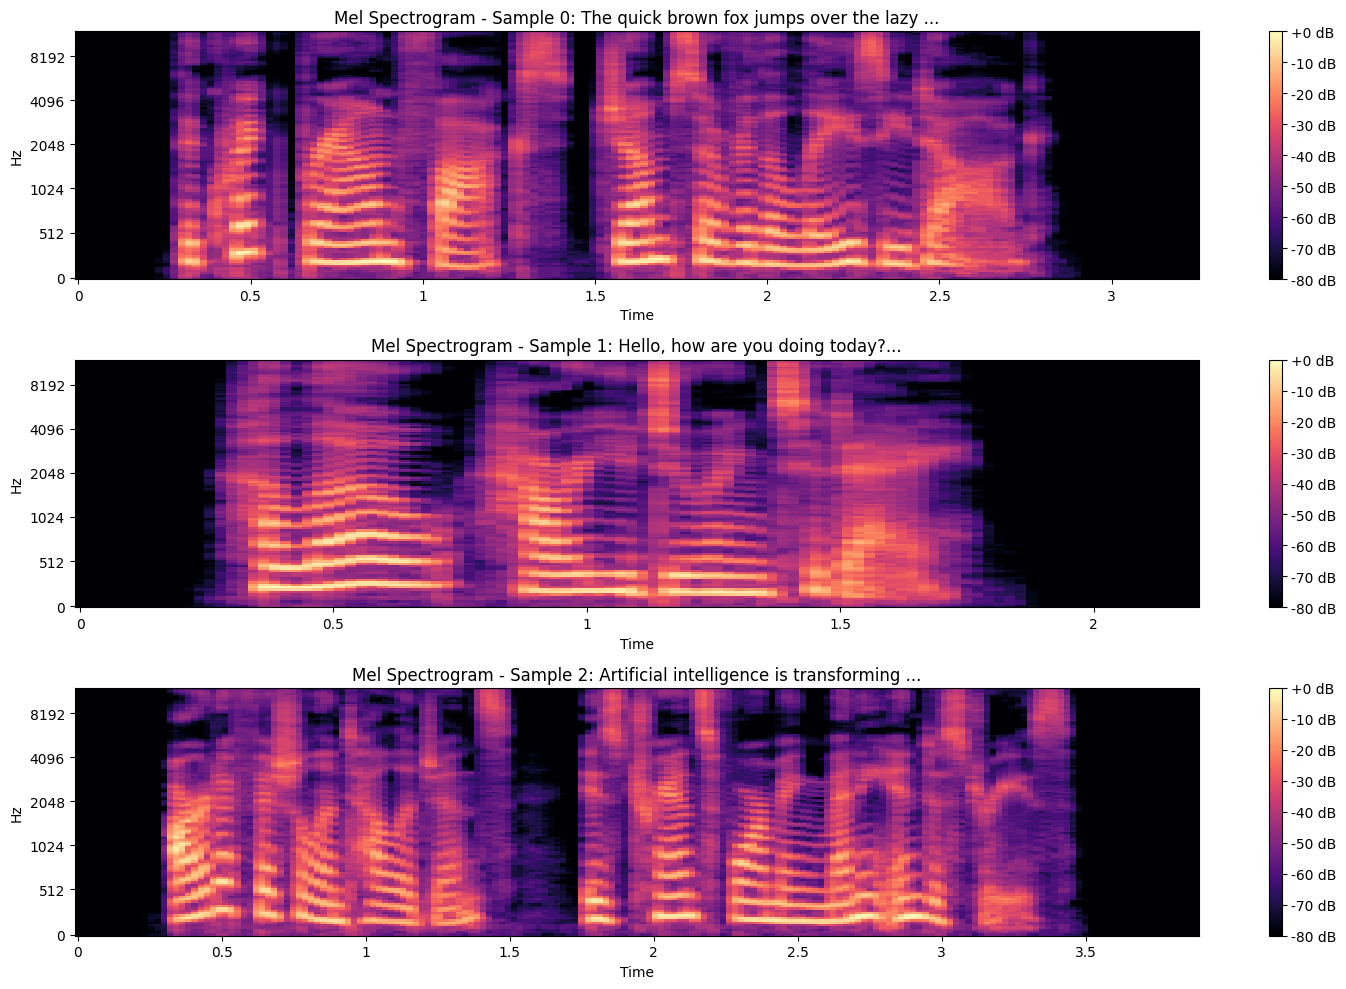

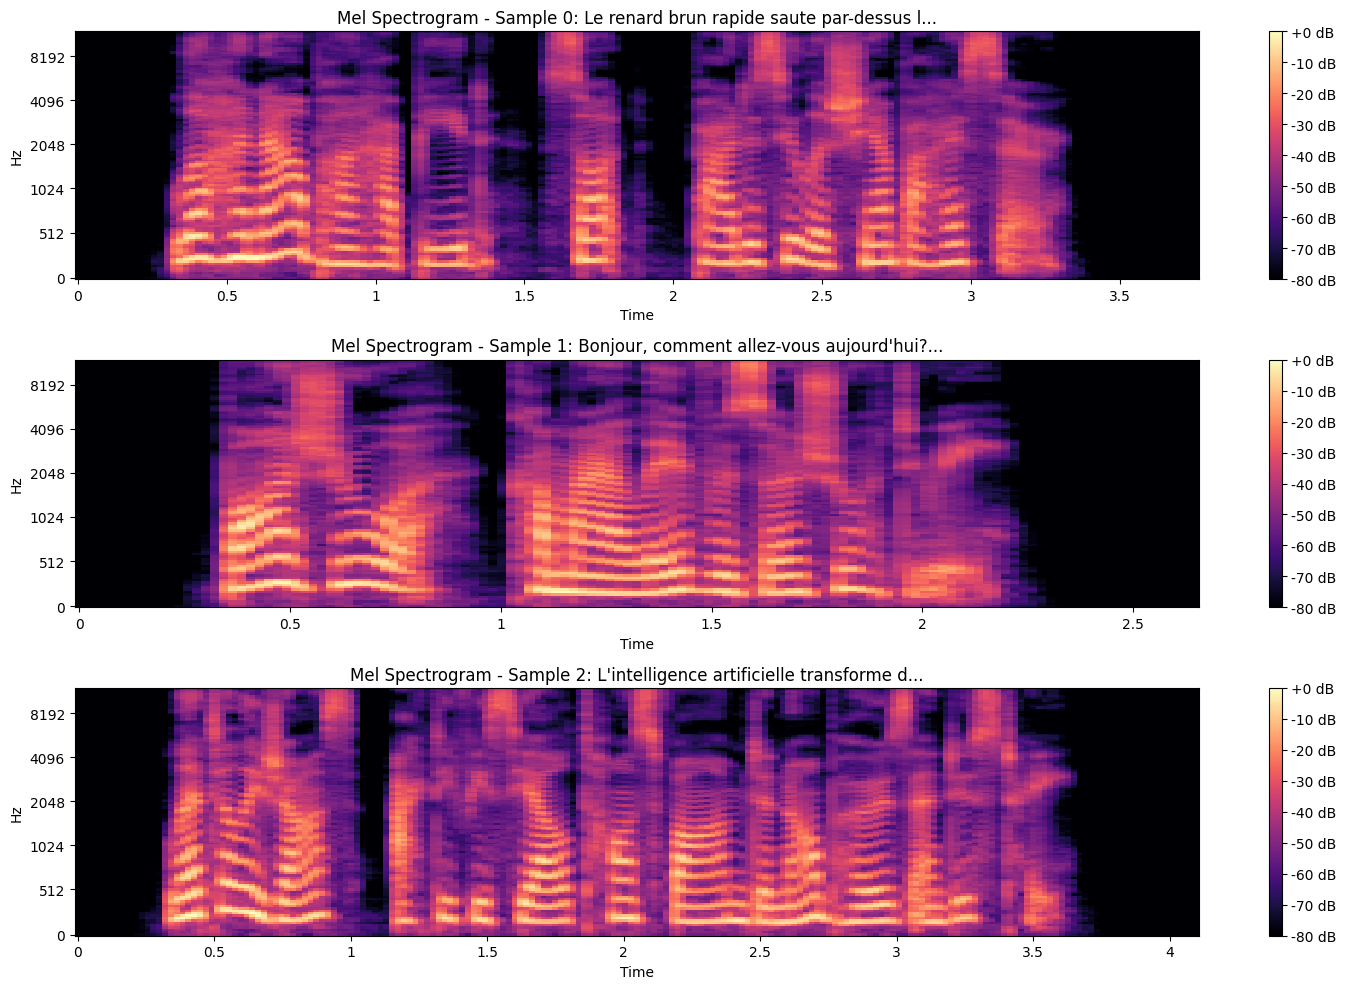

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2332 (\N{DEVANAGARI LETTER JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib

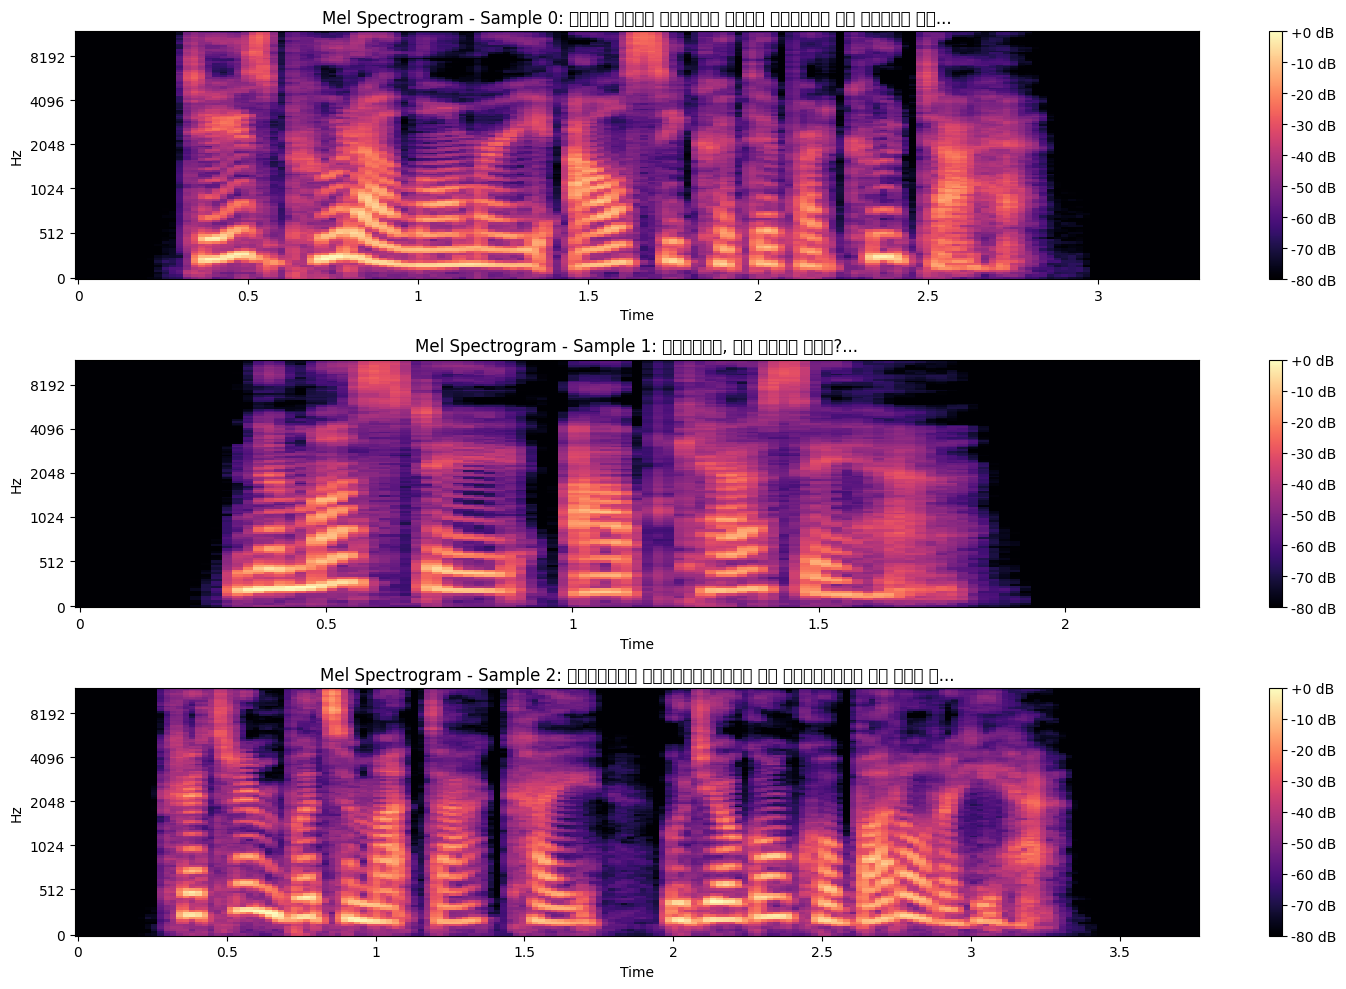

In [33]:
def main():
    """Main function to run all tests"""
    print("="*50)
    print("KOKORO TTS MODEL TESTING SCRIPT")
    print("="*50)


    pipeline = initialize_pipeline(lang_code='a')
    if pipeline is None:
        print("Failed to initialize pipeline. Exiting.")
        return

    results = {}


    test_sentences = prepare_test_data()
    timing_df, output_dir = test_generation_time(pipeline, test_sentences)
    results["basic"] = {"timing_df": timing_df, "output_dir": output_dir}


    analyze_timing_results(timing_df, output_dir)


    quality_df = test_audio_quality(output_dir, test_sentences)
    results["basic"]["quality_df"] = quality_df


    stress_result = stress_test_long_text(pipeline)
    results["stress"] = {"result": stress_result}


    pron_df, phoneme_df, pron_sentences, pron_dir = test_pronunciation(pipeline)
    results["pronunciation"] = {
        "timing_df": pron_df,
        "phoneme_df": phoneme_df,
        "sentences": pron_sentences,
        "output_dir": pron_dir
    }


    speed_df, speed_dir = test_speed_parameters(pipeline)
    results["speed"] = {"speed_df": speed_df, "output_dir": speed_dir}


    voice_df, voice_dir = test_voices(pipeline)
    results["voices"] = {"voice_df": voice_df, "output_dir": voice_dir}


    multi_results = test_multilingual(pipeline)
    results["multilingual"] = multi_results


    summarize_results(results)

    print("\nTest completed successfully!")

if __name__ == "__main__":
   main()